In [7]:
# -*- coding: utf-8 -*-
import numpy as np
from scipy.special import jv, yv
from scipy.stats import qmc
import warnings
from scipy.integrate import quad_vec
import functools

#This function is used to calculate the Mie coefficients a_n and b_n.
#For reference, see the book Bohren & Huffman. The basic solution is given
#in equation (4.53). The version implemented here is from equations
#(4.56) and (4.57), which assume the permeability of particle and
#surrounding medium to be the same!! This is an ASSUMPTION.

#To compute the coefficients we use the equations given in section
#4.8 of the book.

#Inputs: m is the (complex) refractive index of the particle, x is the
#size parameter calculated as 2 * pi * n * r / lambda, and n is the
#refractive index of the medium (assumed to be 1 by default here), r
#is the particle size (radius) and lambda the wavelength of the incoming light
def MieCoefficients_ab(m,x,c=1,mediumindex=1):

  #for x correctly
  x = x* mediumindex.real
  m = m/ mediumindex.real
  mx = m*x

  #A good rule of thumb is that we need about x (size parameter) terms for
  #the sum to give good reslts (start of section 4.8 in Bohren and Huffman)
  #so we set the max sum index to the expression below.
  #c is 1 per default but can be changed in the function input increase
  #the upper bound of the summation.
  nmax = np.amax(np.round(c*(2+x+4*(x**(1/3)))))
  mxmax = np.amax(np.round(np.abs(mx)))

  #this will be used as the max index for the calculation of the
  #D_n below, given in eq. (4.89). The +16 terms are used for initialization
  #and will be dropped later. (see calculation of Dn below)

  nmax_Dn = np.round(max(nmax,mxmax)+16)

  #this will give us the index for the bessel/hankel/etc. functions
  n = np.arange(1,nmax+1) #
  nu = n + 0.5 #
  nu = nu[np.newaxis]
  n = n[np.newaxis]
  #this is the prefactor used to convert the normal bessel functions into
  #the so called Riccati Bessel functions. These are defined in Bohren and
  #Huffman right above equation (4.56)
  prefactor = np.sqrt(0.5*np.pi*x)

  #Here we define the Ricatti functions. The second line is needed because
  #we start at n=1 but we need to add the zeroth function, which is sin(x) for
  #the Ricatti function dubbed Sn and cos(x) for Cn. This effectively shifts
  #the index by 1, which is exactly what we need for the formula (4.88) in
  #the book
  RicattiSn = prefactor*jv(nu.T,x) #
  RicattiSn0 = np.insert(RicattiSn, 0, np.sin(x), 0)
  RicattiSn0 = np.delete(RicattiSn0, -1, 0) #

  RicattiCn = -prefactor*yv(nu.T,x) #
  RicattiCn0 = np.insert(RicattiCn, 0, np.cos(x), 0)
  #RicattiCn0 = np.append(np.cos(x), RicattiCn[0:int(nmax)-1]) #
  RicattiCn0 = np.delete(RicattiCn0, -1, 0)

  RicattiXin = RicattiSn-(0+1j)*RicattiCn #
  RicattiXin0 = RicattiSn0-(0+1j)*RicattiCn0 #

  #Here we add an axis to be able to do the .T command later, where we want to
  #subtract for example the first element from all the columns in the first row.
  #this is done by subtracting a row-vector from the matrix

  #here we define Dn, which is a quantity also needed to calculate the
  #coefficients in (4.88), and the definition of Dn is given in (4.89).
  #each term in the recurrence relation reduces the error signigicantly,
  #which is why here I initiate with zero and calculate more terms then
  #necessary and in the end throw away the first few terms.
  D_n = np.zeros((int(nmax_Dn),len(m)),dtype=complex)
  for i in range(int(nmax_Dn)-1,1,-1):
    D_n[i-1,:] = (i/mx)-(1/(D_n[i,:]+i/mx))


  #Here we drop the terms beyond nmax that we needed to initialize and we
  #start at index 1 because there is no a0 but we start with n=1.
  D_n = D_n[1:int(nmax)+1,:]

  #Here I just define the two factors in brackets from eq. (4.88)
  #Python is amazing here because the array-matrix multiplication does
  #exactly what we want here. multiplying an array with a matrix,
  #the rows are multiplied elementwise with the array and this happens for
  #every row, which is exactly what we want.
  FactorFora_n = D_n/m + n.T/x
  FactorForb_n = m*D_n + n.T/x

  #Now, finally, calculating the coefficients according to eq. (4.88) :D
  a_n = (FactorFora_n*RicattiSn - RicattiSn0) / (FactorFora_n*RicattiXin-RicattiXin0)
  b_n = (FactorForb_n*RicattiSn - RicattiSn0) / (FactorForb_n*RicattiXin-RicattiXin0)
  print(a_n.shape,b_n.size)
  return a_n, b_n



#Here I define a function which is used to calculate the same coefficients as before
#but with the simplifying assumption that we have small particles (compared to the wavelength)
#which means we can approximate the whole thing by just the first few terms.
#This is done in section 5.1 in Bohren and Huffman.
def LowFrequencyMieCoefficients_ab(m,x,mediumindex=1):

  x = x* mediumindex.real
  m = m/ mediumindex.real

  a_1 = (-2j/3) * x**3 * (m**2-1)/(m**2+2)  -  (2j/5) * x**5  * (m**2-1)*(m**2-2)/(m**2+2)**2  +  (4/9) * x**6 * ((m**2-1)/(m**2+2))**2

  b_1 = (-1j/45) * x**5 * (m**2-1)

  a_2 = (-1j/15) * x**5 * (m**2-1)/(2*m**2+3)

  b_2 = 0+0j

  a_n = np.vstack((a_1,a_2))
  b_n = np.vstack((b_1,b_2))
  return a_n , b_n

#This function automatically decides to use the low-frequency approximation if the
#size parameter is smaller than limit, which is set to 0.5 by default. There is
#also an option to switch auto to False, in which case only the full treatment is
#used and no low frequency approximation is used even for small particles.
def AutomaticMieCoefficients_ab(m,x,c=1,mediumindex=1,limit=0.5,auto=True):
    minimum = np.amin(np.abs(x))
    if auto:
        if minimum<limit:
          return LowFrequencyMieCoefficients_ab(m,x,mediumindex)
        else:
          return MieCoefficients_ab(m,x,c,mediumindex)
    else:
        return MieCoefficients_ab(m,x,c,mediumindex)


#Here the angle-dependent functions pi_n and tau_n are calculated
#via a recursion relation as shown in equation (4.47)
def PiTau(angle,nmax):

  mu = np.cos(angle/180*np.pi)

  #This creates a 2D array with zeroes where the columns are the angles
  #(which is why there are 180 columns) and the rows are the pi_n and tau_n
  #for every angle
  pi = np.zeros((int(nmax),len(angle)))
  tau = np.zeros((int(nmax),len(angle)))

  #Here I calculate the first two elements according to relation (4.47) in
  #the book. Caveat!: the zeroth index is actually the element pi_1, tau_1.
  #this is because in the sum we start with n=1 so we don't consider n=0,
  #but it is nevertheless used to calculate n=1 via the relation (4.47)
  pi[0,:] = 1
  pi[1,:] = 3*mu

  tau[0,:] = mu
  #tau[1,:] = 3*(2*mu**2-1)
  tau[1,:] = 3.0*np.cos(2*np.arccos(mu))

  #After initializing the first few elements, now the rest is calculated
  #with the aforementioned recurrence relation
  #Caveat!: the element at index n=0 is actually the term for n=1. so
  #when calculating pi_n, we need to replace n in (4.47) by n+1, because
  #our index lags one behind (index 0 is actually for n=1, etc.)
  for n in range(2,int(nmax)):
    pi[n,:] = (2*n+1)/n * (mu*pi[n-1,:]) - (n+1)/n * pi[n-2,:]
    tau[n,:] = (n+1)*mu * pi[n,:] - (n+2) * pi[n-1,:]
  return pi, tau


#Here the Matrix Elements of the Scattering (2x2) matrix are calculated.
#The formulas for these matrix elements are given in equation (4.74)
#from these formulas we can then calculate the phase functions in the
#mueller matrix
def ScatteringMatrixElements(m,x,angle,c=1,n=1,limit=0.5,auto=True):

  xmax = np.amax(x)
  nmax = np.round(c*(10+xmax+4*np.power(xmax,1/3)))

  #determine the coefficients used to calculate the matrix elements S1 and S2
  #see function description for MieCoefficients_ab above
  a_n, b_n = MieCoefficients_ab(m,x,c,n)
  a_n = a_n[:,np.newaxis,:]
  b_n = b_n[:,np.newaxis,:]

  #Calculate the functions pi and tau needed for the calculation.
  #see function description for PieTau above
  pi_n, tau_n = PiTau(angle,nmax)

  #This gives the matrix a new (3rd) axis. This is needed because we multiply
  #with the a_n and b_n later. why? --> we have two matrices: the pi/tau_n
  #which are all the n's for every angle, and the an/bn, which are all the
  #n's for every refractive index. we now need to multiply the first entry
  #of the pi_n matrix (=pi_1 for angle theta=1) with the entire first row
  #of the index vs. an matrix in order to get pi_1*a_1 at angle theta = 1
  #for every refractive index in the matrix. So every angle gives an entirely
  #new matrix and in the end we have a rank 3 tensor.
  #when we then sum over one axis of this rank 3 tensor, we are left with
  #a rank 2 tensor (=matrix) whose elements then are the ScatteringMatrixElements
  #for each refractive index and each angle. The rows will be the angles
  #and the columns will be the different refractive indices
  pi_n = pi_n[:,:,np.newaxis]
  tau_n = tau_n[:,:,np.newaxis]

  #Here I create an array for the summation in formula (4.74)
  #remember that for all our quantities, the zero-index value is actually
  #the n=1 value. So here an array is created with numeric value 1 in its
  #first entry (= zeroth index) in order to sum properly according to formula (4.74)
  n = np.arange(1,int(nmax)+1)

  #this is the prefactor in the sum (4.74) and needs to be transposed with
  #the nexaxis command in order to multiply the correct entries in the rank 3
  #tensor below
  Prefactor = (2*n+1)/(n*(n+1))
  Prefactor = Prefactor[np.newaxis,np.newaxis]
  Prefactor = Prefactor.T

  #a_n is a matrix with the columns being different refractive indices and the
  #rows being the a_n for these indices, so I need the number or rows to know
  #how many a_n there are, to know until what n to sum.
  UpperSumIndex_a = np.shape(a_n)[0]
  UpperSumIndex_b = np.shape(b_n)[0]

  #finally, actual calculation of the sum (4.74) to get the matrix elements S1 and S2 ;)
  S_1 = np.sum(Prefactor[0:UpperSumIndex_a] * ( pi_n[0:UpperSumIndex_a,:] * a_n + tau_n[0:UpperSumIndex_b,:] * b_n),0)
  S_2 = np.sum(Prefactor[0:UpperSumIndex_a] * (tau_n[0:UpperSumIndex_a,:] * a_n + pi_n[0:UpperSumIndex_b,:] * b_n),0)

  #The returned matrices will have the S-values as entries. Since S depends on the angle and the
  #refractive index, we have "two dimensions". The columns will correspond to different refractive
  #indices and the rows will correspond to different angles. so the entry M_57 in the matrix
  #will be the S-element for the angle of 5 degrees of the 7th refractive index in the data set
  return S_1, S_2


#Here we use equation(s) (4.77) in the book to get the two elements we want
#we want S11 and -S12/S11, which is the polarized phase function
#the radius and the wavelength have to be input with the same units. so if one
#used nanometers for the wavelength, the particle radius needs to be nanometers as well.
def PhaseFunctions(m,wavelength,radius,angle,mediumindex=1.0,limit=0.5,auto=True,c=1):

  #n = n.real
  wavelength = wavelength/mediumindex.real
  x = 2*np.pi*radius/wavelength

  S_1, S_2 = ScatteringMatrixElements(m,x,angle,c,mediumindex,limit,auto)

  S_11 = 0.5*(np.abs(S_2)**2+np.abs(S_1)**2)
  S_12 = 0.5*(np.abs(S_2)**2-np.abs(S_1)**2)

  #PPF: polarized phase function
  PPF = -S_12/S_11

  return S_11, PPF



#This function integrates over a particle size distribution
def sizedistribution(r, Vtot, sigma, rmean):
    return Vtot/(np.sqrt(2*np.pi)) * 1/sigma * 1/(r/1000) * np.exp(-(np.log(r)-np.log(rmean))**2/(2*sigma**2))

#This creates a matrix where every row is a new set of parameters and every column consists of different values for the
#same parameter. It uses LatinHypercube sampling, meaning (roughly) it chooses random values from a n-dimensional cube with
#specific size-bounds that can be set in the input
def CreateParameterMatrix(SampleSize, RealIndexBounds, ImaginaryIndexBounds, SigmaBounds, MeanRadiusBounds, VolumeConcentrationBounds):

    #This creates a matrix with random entries which has 5 columns (=number of parameters we want)
    #and as many rows as we want to, which will correspond to the samplesize we choose
    sampler = qmc.LatinHypercube(d=5)
    sample = sampler.random(n=SampleSize)

    #This creates the lower and upper bounds for the parameters which are also taken as input values
    LowerBounds = np.array([RealIndexBounds[0], ImaginaryIndexBounds[0], SigmaBounds[0], MeanRadiusBounds[0], VolumeConcentrationBounds[0]])
    UpperBounds = np.array([RealIndexBounds[1], ImaginaryIndexBounds[1], SigmaBounds[1], MeanRadiusBounds[1], VolumeConcentrationBounds[1]])

    #This rescales all the created random values in the matrix to match the lower and upper bounds that we set
    sample = qmc.scale(sample, LowerBounds, UpperBounds)

    #This makes a pandas dataframe out of the sample matrix
    Data = pd.DataFrame(sample, columns=['RealRefractiveIndex', 'ImaginaryRefractiveIndex', 'Sigma', 'MeanRadius', 'VolumeConcentration'])

    return Data


def SinglePhaseFunctionsFromParameterSet(ParameterSet, wavelength, mediumindex=1.0, limit=0.5, auto=True, c=1):

    RefractiveIndex = ParameterSet['RealRefractiveIndex'].to_numpy() + (0+1j)*ParameterSet['ImaginaryRefractiveIndex'].to_numpy()
    RelativeIndex = RefractiveIndex/mediumindex

    Radius = ParameterSet['MeanRadius'].to_numpy()

    Angles = np.arange(1,180)

    S_11, PPF = PhaseFunctions(RelativeIndex,wavelength,Radius,Angles,mediumindex=mediumindex,limit=limit,auto=auto,c=c)

    return S_11, PPF


def sizedistribution(r, Vtot, sigma, rmean):
    return Vtot/(np.sqrt(2*np.pi)) * 1/sigma * 1/r * np.exp(-(np.log(r)-np.log(rmean))**2/(2*sigma**2))

def integrand(radius, m, wavelength, mediumindex, angle, Vtot, sigma, rmean, c, limit, auto):

            wavelength = wavelength/mediumindex.real
            x = 2*np.pi*radius/wavelength

            S_1, S_2 = ScatteringMatrixElements(m,x,angle,c,mediumindex,limit,auto)

            S_11 = 0.5*(np.abs(S_2)**2+np.abs(S_1)**2)
            S_12 = 0.5*(np.abs(S_2)**2-np.abs(S_1)**2)

            #PPF: polarized phase function
            PPF = -S_12/S_11

            return (S_11*sizedistribution(radius, Vtot, sigma, rmean))
    
def EnsemblePhaseFunctions(m, wavelength, Vtot, sigma, rmean, radiusbounds = np.array([50,3000]),angle=np.arange(1,181), mediumindex=1.0, limit=0.5, auto=True, c=1):

    PartialIntegrand = functools.partial(integrand, m=m, wavelength=wavelength, mediumindex=mediumindex, angle=angle, Vtot=Vtot, sigma=sigma, rmean=rmean, c=c, limit=limit, auto=auto)

    IntegratedMatrix = quad_vec(PartialIntegrand,radiusbounds[0],radiusbounds[1],workers=-1)

    return IntegratedMatrix

def IntegratedEnsembleMatrixFromParameterSet(ParameterSet, wavelength, radiusbounds = np.array([50,3000]), angles = np.arange(1,181), mediumindex=1.0, limit=0.5, auto=True, c=1):

        RefractiveIndex = ParameterSet['RealRefractiveIndex'].to_numpy() + (0+1j)*ParameterSet['ImaginaryRefractiveIndex'].to_numpy()
        RelativeIndex = RefractiveIndex/mediumindex
        Vtot = ParameterSet['VolumeConcentration'].to_numpy()
        sigma = ParameterSet['Sigma'].to_numpy()
        rmean = ParameterSet['MeanRadius'].to_numpy()

        IntegratedMatrix = EnsemblePhaseFunctions(RelativeIndex, wavelength, Vtot, sigma, rmean, radiusbounds=radiusbounds, angle=angles, mediumindex=mediumindex, limit=limit, auto=auto, c=c)

        return IntegratedMatrix

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Mie Package Documentation

#### This Notebook explains the main functions present in the MiePackage script - how to use them and what they do.

#### Let's start with the function *ScatteringMatrixElements(m,x,angle,c=1,n=1,limit=0.5,auto=True):*

It calculates the Matrix Elements S1 and S2 of the Scattering Matrix, which is the 2x2 Matrix acting on the vector with components of the parallel and perpendicular electric field. These elements can be used on their own but are also used in another function to directly calculate P11 and P12, which are the matrix elements we are interested in.

The inputs are

- m: refractive index of particle / medium refractive index
- x: size parameter
- angle: an array from 1 to 180 (or whatever angles you want)
- c: higher values compute higher limits of the sum
- n: refractive index of the medium

The size parameter is calculated with x = 2 * pi * R / lambda, where R is the particle radius (sphere) and lambda the incident wavelength.

(3834, 2) 7668


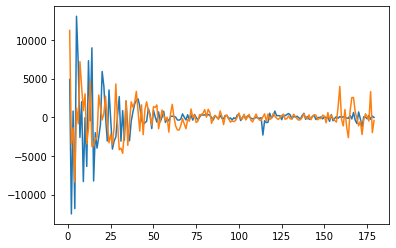

In [10]:
m = np.array([1.2,1.5])
wavelength = 532
particleradius = 600
x = 2*np.pi*particleradius
angle = np.arange(1,180)


S1, S2 = ScatteringMatrixElements(m,x,angle,c=1,n=1)

plt.figure()
plt.plot(angle, S1.real)

As can be seen, S1 has elements for all the angles form 1 to 180 for both refractive indices (since we used an array with two entries for m as input)

#### The PhaseFunctions(m,wavelength,radius,angle,mediumindex=1.0,c=1) function directly calculates the S1 and S2 and uses them to calculate P11 and PPF (= -P12/P11), which is what we actually want.

(17, 2) 34


Text(0.5, 1.0, 'Polarized Phase Function')

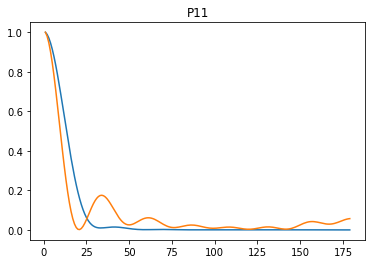

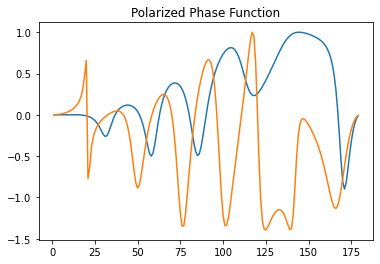

In [11]:
P11, PPF = PhaseFunctions(m,wavelength,particleradius,angle)

plt.figure()
plt.plot(angle, P11[:,0]/max(P11[:,0]))
plt.plot(angle, P11[:,1]/max(P11[:,1]))
plt.title('P11')

plt.figure()
plt.plot(angle, PPF[:,0]/max(PPF[:,0]))
plt.plot(angle, PPF[:,1]/max(PPF[:,1]))
plt.title('Polarized Phase Function')

#### Now lets say we want to create our own dataset. This can be done with the CreateParameterMatrix()-function

It has the following inputs:

- Samplesize: How many samples you want
- RealIndexBounds: an array with two entries which confine the real part of the refractive index in your sample
- ImaginaryIndexBounds: same as RealIndexBounds but for imaginary part
- SigmaBounds: same as the other bounds but for the sigma of the size distribution you are using
- MeanRadiusBounds: you get it.. ;)
- VolumeConcentrationbounds: ..

In [12]:
SampleSize = 20
RealIndexBounds = np.array([1.3,1.8])
ImaginaryIndexBounds = np.array([0.0,0.2])
SigmaBounds = np.array([1.30,1.50])
MeanRadiusBounds = np.array([100,3000])
VolumeConcentrationBounds = np.array([1,5000])


Parameters = CreateParameterMatrix(SampleSize, RealIndexBounds, ImaginaryIndexBounds, SigmaBounds, MeanRadiusBounds, VolumeConcentrationBounds)


In [13]:
Parameters.columns = ['RealRefractiveIndex', 'ImaginaryRefractiveIndex', 'Sigma','MeanRadius', 'VolumeConcentration']
Parameters

RealRefractiveIndex  ImaginaryRefractiveIndex     Sigma   MeanRadius  \
0              1.528288                  0.045644  1.314165   635.495065   
1              1.455153                  0.163118  1.347677  1337.944003   
2              1.574186                  0.107820  1.335164  1871.596528   
3              1.400733                  0.128475  1.403889  1594.267830   
4              1.619701                  0.172180  1.417184   732.148218   
5              1.744747                  0.029981  1.471265  1483.181109   
6              1.516014                  0.037512  1.328346  1768.232729   
7              1.395744                  0.014146  1.480388   833.687241   
8              1.323959                  0.058914  1.469328  1002.080254   
9              1.702981                  0.144732  1.437387  1232.931915   
10             1.693970                  0.085414  1.392422  2842.763497   
11             1.498910                  0.092765  1.453633  2599.856418   
12             1.588095                  0.155243  1.499157   456.689696   
13             1.643620                  0.197772  1.364408  2292.957951   
14             1.654200                  0.188688  1.444933  2168.698559   
15             1.763165                  0.069521  1.351209  2033.581605   
16             1.796482                  0.077457  1.421045   329.659639   
17             1.446995                  0.003665  1.376789  2860.709765   
18             1.373542                  0.119444  1.381344  2546.423441   
19             1.340245                  0.135866  1.301161   156.817284   

    VolumeConcentration  
0            127.210668  
1           2240.345799  
2           3496.055222  
3           3044.955472  
4           3813.089100  
5            666.487393  
6            984.683660  
7           2402.798331  
8           2730.650690  
9           3706.610561  
10          4338.105651  
11          4511.345267  
12           276.504042  
13          4960.172111  
14          1747.330387  
15          4208.504305  
16          1153.733223  
17          2989.069904  
18          1774.830577  
19          1311.133691

As you can see, 12 sets of parameters have been created with values between the given bounds.

#### Using this Parameterset we can directly input it into the SinglePhaseFunctionsFromParameterSet()-function to get the Phase Functions for a single radius (meaning *not* averaged over the size distribution.

(49, 20) 980


Text(0.5, 1.0, 'Polarized Phase Functions')

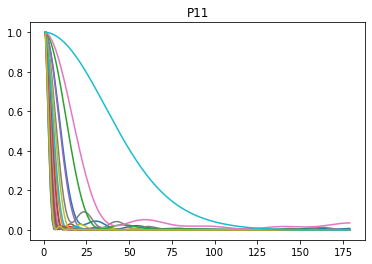

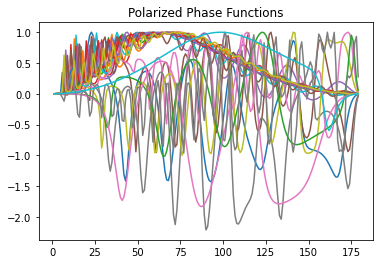

In [14]:
P11, PPF = SinglePhaseFunctionsFromParameterSet(Parameters, wavelength)

plt.figure()
for i in range(len(P11[1,:])):
    plt.plot(angle, P11[:,i]/max(P11[:,i]))
plt.title('P11')
    
plt.figure()
for i in range(len(PPF[1,:])):
    plt.plot(angle, PPF[:,i]/max(PPF[:,i]))
plt.title('Polarized Phase Functions')

#### If we want an Ensemble Average over a size distribution we can use the IntegratedEnsembleMatrixFromParameterSet()-function and input our parameterset.

In [15]:
wavelength = 532
Ensemble = IntegratedEnsembleMatrixFromParameterSet(Parameters, wavelength)[0]

(50, 20) 1000
(50, 20) 1000
(49, 20) 980
(48, 20) 960
(46, 20) 920
(44, 20) 880
(42, 20) 840
(39, 20) 780
(37, 20) 740
(34, 20) 680
(30, 20) 600
(27, 20) 540
(24, 20) 480
(21, 20) 420
(18, 20) 360
(16, 20) 320
(13, 20) 260
(11, 20) 220
(9, 20) 180
(7, 20) 140
(6, 20) 120
(30, 20) 600
(30, 20) 600
(30, 20) 600
(29, 20) 580
(28, 20) 560
(27, 20) 540
(26, 20) 520
(24, 20) 480
(23, 20) 460
(21, 20) 420
(20, 20) 400
(18, 20) 360
(16, 20) 320
(15, 20) 300
(13, 20) 260
(11, 20) 220
(10, 20) 200
(9, 20) 180
(7, 20) 140
(7, 20) 140
(6, 20) 120
(51, 20) 1020
(50, 20) 1000
(50, 20) 1000
(49, 20) 980
(48, 20) 960
(47, 20) 940
(46, 20) 920
(45, 20) 900
(44, 20) 880
(42, 20) 840
(41, 20) 820
(39, 20) 780
(38, 20) 760
(36, 20) 720
(35, 20) 700
(34, 20) 680
(33, 20) 660
(32, 20) 640
(31, 20) 620
(31, 20) 620
(31, 20) 620
(20, 20) (41, 20)400
 820(20, 20) 400

(19, 20) 380
(19, 20) 380
(18, 20) 360
(41, 20)(18, 20) 820
 360
(40, 20)(17, 20)  800340

(40, 20) (16, 20)800 
320
(40, 20)(16, 20)  800
320
(

 660560(38, 20)
(44, 20)
(49, 20)  980 (33, 20)
880760
(49, 20) 980

 (44, 20)660 
(38, 20)(49, 20)880  760

980
(49, 20)(43, 20)  980
860
(49, 20) 980
(43, 20) 860
(48, 20)(43, 20) 860
 960
(43, 20) 860
(48, 20)(43, 20) 860
 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(49, 20)(44, 20) 980(37, 20)(32, 20)(18, 20)(34, 20)(12, 20)  (42, 20)(27, 20)(47, 20)(29, 20)(21, 20)(24, 20)(15, 20)(39, 20)    740(8, 20) 640
   840540360
680    880 580240
480940160420


300780








(12, 20)(18, 20)
(27, 20)(15, 20)(32, 20)(24, 20) (21, 20)(29, 20)   (37, 20) (8, 20) (49, 20)540(34, 20)240300   640 360480 420(44, 20)
 (42, 20)740

160680(47, 20)(39, 20)


580980(27, 20)
 
 

 (15, 20)
 880 (12, 20)(18, 20) 940(8, 20)(21, 20)
(32, 20)780(24, 20)(34, 20)840(37, 20)300540 
  
  (49, 20)
 
 
360 420240640160680 
(29, 20)480(15, 20)


(44, 20)(47, 20)

(26, 20)(39, 20) 980
(42, 20)(12, 20)(18, 20) 740 
(24, 20)  (32, 20)580  940

(8, 20)300 (34, 20)   (21, 20)880240
780360640

480  
 840
520(37, 20)

(4

(47, 20)(37, 20) 
 
 (42, 20)
(21, 20)360700(29, 20)800 480(32, 20)


 740 
940  (50, 20)(24, 20)840 
640(45, 20)(18, 20)
(35, 20)420
480
 
 580(40, 20) (37, 20)900700
 1000
 (42, 20)(47, 20)800
(32, 20) 
 360
 740
 940840
(29, 20)

 640
(50, 20)(40, 20)(34, 20)(47, 20) 580680 
(45, 20) 
940 (42, 20)
  (29, 20)
8409008001000(37, 20)(34, 20)
 

 
580
(40, 20)(42, 20)  840800

 740(50, 20)
(45, 20)680(40, 20) (47, 20)(42, 20)  (37, 20)940 840
1000 
 900
740800



(34, 20)(50, 20) (47, 20)(42, 20)(37, 20)(45, 20)  6801000
940(39, 20)  
 
 (34, 20)900840780740
 

680

(50, 20)(47, 20)(44, 20) 880(42, 20)  (39, 20) 840 
1000
780940(42, 20)


(44, 20) (47, 20) 940 840(39, 20)880
(49, 20)

 780
 (47, 20)980 940
(44, 20)
 (47, 20) 940
880
(49, 20)(44, 20)  980880

(49, 20) 980
(49, 20) 980
(49, 20) 980
(27, 20)(48, 20)(34, 20)(44, 20)(23, 20)(38, 20)(41, 20)(43, 20)(31, 20)(45, 20)(30, 20)(32, 20) (46, 20) (40, 20)(25, 20)(39, 20) (49, 20)(36, 20)820      540 (18, 20)(26, 20)   (35, 20)  (50, 

  (8, 20)460420
 
(12, 20)540400


580 (46, 20)
300(14, 20)(10, 20)
760


640680 360340 
 (28, 20)780

(33, 20)
   480
(43, 20)(47, 20)
(49, 20)240 (21, 20)(23, 20)
280(15, 20)
920 (17, 20)(42, 20)(48, 20)(20, 20)(27, 20)(44, 20)(29, 20) 

620160


  560200(25, 20) 


(24, 20)   (36, 20)(37, 20)   980(18, 20)(41, 20)660
(32, 20)  880400
580540(39, 20)    860
300 (8, 20) 460
420
940(12, 20)(14, 20) (38, 20)340

720(34, 20) 
740

 960840
500
 (31, 20)360640(10, 20)(46, 20) 480
 


(28, 20)(20, 20)
 (28, 20)780(29, 20)(49, 20) 
820 
 

(43, 20)160280
(17, 20) 760(44, 20)(15, 20)
(23, 20)  680  240(21, 20)
(20, 20)(27, 20)(36, 20)
 (34, 20)620(47, 20)
200(37, 20)(32, 20) 920 (25, 20)

560  
  400

 560(42, 20)980  
 880460340

(10, 20)420(39, 20)  860580
 740
540(12, 20) 940 300(14, 20)
(38, 20)
680
(30, 20)(21, 20) 

(28, 20)(34, 20) 720
640(14, 20)840
 400

(41, 20) 
(24, 20)(49, 20)(48, 20)


500 (21, 20)(18, 20) 
 780 (46, 20)
  (29, 20)(27, 20)

280200240(34, 20)   (30, 20)(37, 20) 76

(15, 20)(44, 20)(34, 20) 
400(38, 20)800260
 (30, 20)900   (49, 20)

500780

(26, 20)660


860220(41, 20)(36, 20)  (48, 20)(18, 20) 
(22, 20)
380 880 320(50, 20)760(13, 20) 
(31, 20)
 

 980
600

300
(23, 20) 580(20, 20)(9, 20) 440 (40, 20)(46, 20)
1000(16, 20)(44, 20)
(11, 20) 
 (35, 20) 360680
(25, 20)960(43, 20)(45, 20) 520
  (39, 20)(32, 20)620      

(30, 20)   400
260
 920320880(29, 20)
 (15, 20)820720460
220800700(22, 20) 640860900780
180


500
(48, 20)(38, 20)  


(49, 20) 

(31, 20)440

600



(50, 20)
(34, 20)(16, 20)300  (23, 20)(41, 20)  (44, 20)
(20, 20)(36, 20)
580980   760620 (40, 20)
(32, 20) 960
(39, 20)(45, 20) (46, 20)(43, 20)1000(35, 20) 820  460(15, 20) 
(22, 20)
320

 
680 720   
880640 400
(29, 20)
780

900(48, 20)(38, 20)800920700
 860




440  300


(49, 20)
 (50, 20)(36, 20)
(44, 20)(46, 20)960580
(32, 20)(41, 20)  (45, 20)(39, 20) (35, 20)(40, 20)
 760 (43, 20)720 980

1000880     800700
900920

 820

780

640


(38, 20)860
(44, 20)(48, 20)(41, 20)(32, 20)(45

800720 (19, 20)(25, 20)860     (28, 20)500 
(17, 20)
  760420640  
  
1000 540 440480
 (41, 20)(31, 20)(38, 20)(23, 20)(30, 20)(27, 20)(31, 20)880(41, 20)(48, 20)  

(49, 20)(45, 20)900 700580680
740720660
(43, 20)780580

300(46, 20)
460  380   
  660840

 (40, 20)

  
9607001000

(47, 20) 560(26, 20) 
(46, 20)500


(40, 20)
(25, 20)(36, 20)
(43, 20)(38, 20) 820
620960460 340540
(22, 20)
980
 600 760
 820620 
(24, 20)

(33, 20)(37, 20)
(34, 20)900
(27, 20)(29, 20)(21, 20)(39, 20)(29, 20)860    (45, 20) (35, 20)(32, 20)(49, 20)

(36, 20)(44, 20)(15, 20)


 800(19, 20)


520


 920920940 (25, 20) (28, 20) (42, 20)   
(23, 20) 
(48, 20)720(50, 20)  (33, 20)   (34, 20) 760(41, 20)800500860
 (31, 20)440(17, 20)  (23, 20) 

(38, 20)

(27, 20)780(48, 20)(30, 20) 580(41, 20)660(31, 20) 480640 680540 
420580980 700(49, 20)740 900 



300 380(43, 20)880(45, 20)560(26, 20)
 720 (40, 20)

 
6601000
680 
 840  
820(46, 20)(43, 20)(46, 20)(22, 20)760

 460



 
500960540 
 
(36, 20)(25, 20)(29, 20)


680(41, 20) (30, 20) (22, 20)(39, 20) 
 (32, 20)460
(46, 20)440940  (50, 20)300(30, 20)540 (42, 20)(37, 20)880 1000(38, 20)640 
800    (26, 20)(31, 20)

840
480680  

520 
940
560 900 (19, 20)700(39, 20) 
480 (33, 20) 
  740720
 


 500
(34, 20) 340(48, 20)820580980 (46, 20)


(23, 20)
600
640920

820780

(22, 20) (27, 20)8401000740 440(44, 20)560
760
 (32, 20)600(35, 20)(43, 20)
 
520(47, 20)(15, 20)(40, 20)(24, 20)(49, 20) 
 

620(24, 20) (26, 20)
(34, 20)
(44, 20)
 (50, 20) 
380660(28, 20) (47, 20)

780 



 
(17, 20) 
(35, 20)(42, 20)680    (29, 20)(25, 20)(36, 20)460 (37, 20)960
  
920 (41, 20)(30, 20)(45, 20)(49, 20)540   (22, 20)
440 
700 860300480480

 (30, 20)
(38, 20) (32, 20) 640940 (46, 20)
   880 
800 (42, 20)(39, 20)680980(19, 20)(50, 20)(28, 20)(26, 20)(31, 20)(37, 20)(23, 20)
1000880520  (41, 20)
(39, 20)560940


  (27, 20)700(33, 20)
580
500  840740

340
720(24, 20)
    820 (33, 20)

440 

600(48, 20)
 980 

  (35, 20)
900  (22, 20)(15, 20)920 (24, 20)

640(46, 20)600(

 (44, 20)320 
 (42, 20) 
600 560 760(26, 20)(31, 20)
(32, 20)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



380340960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960
(48, 20) 960


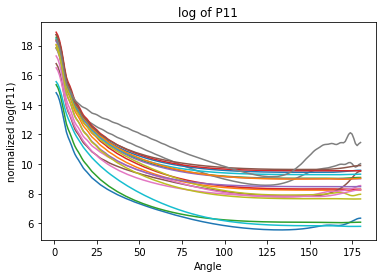

In [16]:
angle = np.arange(1,181)
plt.figure()
for i in range(len(Ensemble[1,:])):
    plt.plot(angle, np.log(Ensemble[:,i]))
plt.xlabel('Angle')
plt.ylabel('normalized log(P11)')
plt.title('log of P11')
plt.show()

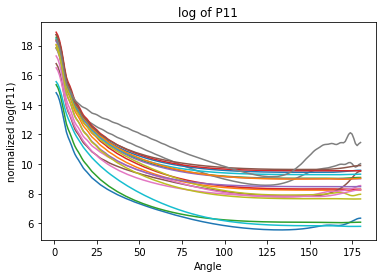

In [17]:
angle = np.arange(1,181)
plt.figure()
for i in range(len(Ensemble[1,:])):
    plt.plot(angle, np.log(Ensemble[:,i]))
plt.xlabel('Angle')
plt.ylabel('normalized log(P11)')
plt.title('log of P11')
plt.show()